# Setup

In [1]:
import matplotlib.dates as mdates
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import matplotlib.style as style
import os
import pandas as pd
import seaborn as sns

In [2]:
sa_palette = sns.color_palette()

In [3]:
style.use("fivethirtyeight")

In [4]:
root_path = "/Users/jmcontreras/jm-contreras"
bo_path = os.path.join(root_path, "covid19-bolivia")
pop_path = os.path.join(root_path, "COVID-19/csse_covid_19_data")
sa_path = os.path.join(root_path, "COVID-19/csse_covid_19_data/csse_covid_19_daily_reports")
plots_path = os.path.join(root_path, "bolivia-covid-19/daily_plots")

In [5]:
# Files with Bolivian data
bo_fnames = {
    "Confirmed": "confirmados.csv",
    "Deaths": "decesos.csv",
    "Discarded": "descartados.csv",
    "Recovered": "recuperados.csv",
    "Suspicious": "sospechosos.csv",
}

# Populations of Bolivian states (from https://bit.ly/3alv1GM)
bo_pop = {
    "La Paz": 2926996,
    "Cochabamba": 2028639,
    "Santa Cruz": 3370059,
    "Oruro": 551116,
    "Potosí": 901555,
    "Tarija": 583330,
    "Chuquisaca": 637013,
    "Beni": 480308,
    "Pando": 154355,
}

# Names of South American countries to compare
sa_names = [
    "Argentina",
    "Bolivia",
    "Brazil",
    "Chile",
    "Colombia",
    "Ecuador",
    "Paraguay",
    "Peru",
    "Uruguay",
]

In [6]:
def get_bo_data():

    for col, fname in bo_fnames.items():
        
        # Read each CSV one at a time 
        df_in = pd.read_csv(os.path.join(bo_path, fname))
        
        # Melt it to one row per date per state
        df_in = df_in.melt(
            id_vars="Fecha",
            var_name="Province_State",
            value_name=col,
        )
        
        # If we don't have an output DataFrame yet, make one
        if "df_out" not in locals():
            df_out = df_in
            
        # If we have one already, merge this CSV's data to it
        else:
            df_out = df_out.merge(
                df_in,
                how="outer",
                on=["Fecha", "Province_State"],
            )

    return df_out


def get_sa_data(country_filter):

    df = pd.DataFrame()

    # Get all files in the data path
    fname_list = os.listdir(path=sa_path)
    fname_list.sort()

    for fname in fname_list:

        if fname.endswith(".csv"):

            # Read CSV
            df_fname = pd.read_csv(
                os.path.join(sa_path, fname)
            )

            # Filter to specific row(s) based on country
            col_filter = df_fname.columns.values[df_fname.columns.str.contains("Country")][0]
            df_fname_filter = df_fname[df_fname[col_filter].isin(country_filter)]

            # Append to single dataframe
            df = pd.concat(
                (df, df_fname_filter),
            )
            
    return df


def clean_sa_data(df):
    
    # Make a copy of the input data
    df = df.copy(deep=True)

    # Find columns missing all data and add them to a list of columns to drop
    is_null_all = df.isnull().all()
    cols_to_drop = is_null_all[is_null_all].index.tolist()

    # Coalesce country/region and last update columns
    df["Country_Region"].update(df["Country/Region"])
    df["Last_Update"].update(df["Last Update"])

    # Extend the list of columns to drop
    cols_to_drop.extend(
        [
            "Latitude",
            "Longitude",
            "Lat",
            "Long_",
            "Combined_Key",
            "Last Update",
            "Country/Region",
        ]
    )

    # Drop these columns
    df.drop(columns=cols_to_drop, inplace=True)
    
    # Drop rows without any quantitative data
    df.dropna(how="all", subset=["Confirmed", "Deaths", "Recovered", "Active"], inplace=True)
    
    # Drop duplicates
    df.drop_duplicates(inplace=True)
    
    return df


def add_roll_column(x):
    
    return x.diff().fillna(value=x.iloc[0])


def prep_data(df, col_date, col_group):
    
    def fill_missing_add_new_count_days(x):
    
        # Fill-in missing dates and forward-fill missing values
        x = x.reindex(
            labels=pd.date_range(
                start=x.index.min(),
                end=x.index.max(),),
            method="ffill"
        )
        
        # Add new rolling columns
        x["Confirmed_New"] = add_roll_column(x["Confirmed"])
        
        # Add days since first confirmed column
        x["Day_Count"] = (x.index - x.index.min()).days
    
        return x
    
    df = df.copy(deep=True)
    
    # Recast dates as datetime and set them as index
    df[col_date] = pd.to_datetime(df[col_date])
    df.set_index(df[col_date].dt.date, inplace=True)
    df.index.name = "Date"
    
    # For dates with multiple rows, keep their most recent row
    df = df.groupby(
        by=["Date", col_group],
        group_keys=False,
    ).apply(
        lambda x: x.sort_values([col_date, "Confirmed"]).tail(n=1),
    )
    
    # Fill-in missing dates, forward-fill missing values, and create new column
    df = df.groupby(
        by=col_group
    ).apply(
        fill_missing_add_new_count_days
    ).reset_index(
        level=col_group,
        drop=True,
    )
    
    return df

# Get, clean, and prepare data

In [7]:
# Get and prepare Bolivian data
df_bo = get_bo_data()
df_bo = prep_data(df_bo, col_date="Fecha", col_group="Province_State")

# Create columns for tested cases and positive rate
df_bo["Tested"] = df_bo["Confirmed"] + df_bo["Discarded"]
df_bo["Tested_New"] = df_bo.groupby(by="Province_State")["Tested"].apply(add_roll_column)
df_bo["Positive_Rate"] = df_bo["Confirmed_New"] / df_bo["Tested_New"]
df_bo["Population"] = df_bo["Province_State"].map(bo_pop)
df_bo["Tested_Per_100k"] = df_bo["Tested"] / df_bo["Population"] * 100000

In [8]:
# Get, clean, and prepare South American data
df_sa = get_sa_data(sa_names)
df_sa = clean_sa_data(df_sa)
df_sa = prep_data(df_sa, col_date="Last_Update", col_group="Country_Region")

# Draw plots

In [27]:
def draw_plots(df, by, x, y, pe_linewidth=0):
    for i, key_grp in enumerate(df.groupby(by=by)):
        key, grp = key_grp
        grp.plot(
            x=x,
            y=y,
            label=key,
            ax=ax,
            color=sa_palette[i],
            path_effects=[
                pe.Stroke(linewidth=pe_linewidth, foreground="black"),
                pe.Normal()
            ],
        )

def add_subtitle(ax, x_min, x_max, y_min, offset_line, offset_signature, offset_subtitle):
    
    # Add thicker horizontal axis
    ax.axhline(
        y=0,
        color="black",
        linewidth=1.3,
        alpha=0.7,
        zorder=1,
    )

    # Add subtitle
    line = "_" * (int(x_max * offset_line))
    signature = "Juan Manuel Contreras (@juanmaphd) con datos de Johns Hopkins University"
    ax.text(
        x=-(x_min + .1) * 38,
        y=-y_min * offset_subtitle,
        s=f"{line}\n{' ' * int(x_max * offset_signature)}{signature}",
        color="grey",
        alpha=.7
    )

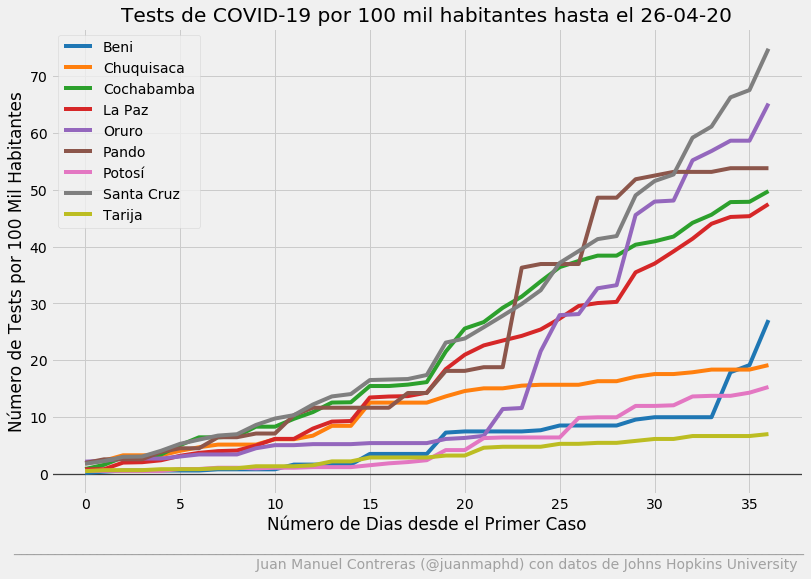

In [34]:
# Create plot object
fig, ax = plt.subplots(figsize=(12, 8))

draw_plots(
    df=df_bo,
    by="Province_State",
    x="Day_Count",
    y="Tested_Per_100k"
)

# Add title and axes labels
plt.title(f"Tests de COVID-19 por 100 mil habitantes hasta el {df_bo.index.max().strftime('%d-%m-%y')}",)
plt.ylabel("Número de Tests por 100 Mil Habitantes")
plt.xlabel("Número de Dias desde el Primer Caso")

# Add thicker horizontal axis
add_subtitle(
    ax,
    x_min=df_bo["Day_Count"].min(),
    x_max=df_bo["Day_Count"].max(),
    y_min=df_bo["Tested_Per_100k"].min(),
    offset_line=3.15,
    offset_signature=1.5,
    offset_subtitle=80,
)

# Draw plot
plt.show()

# Save plot
ax.get_figure().savefig(os.path.join(plots_path, f"bolivia_tests_per_100k_{df_bo.index.max().strftime('%d_%m_%y')}.png"))

# Load population data

In [61]:
df_sa_pop = pd.read_csv(
    os.path.join(countries_path, "UID_ISO_FIPS_LookUp_Table.csv")
)

In [109]:
df_bo_pop = pd.DataFrame.from_dict(
    bo_population,
    orient="index",
).reset_index(
).rename(columns={
    "index": "Province_Region",
    0: "Population",
})

# Get, clean, and prepare data

In [47]:
# Latin America
df_sa = get_data(sa_countries)
df_sa = clean_data(df_sa)
df_sa = prep_data(df_sa)

# Bolivia
df_bo = df_sa[df_sa["Country_Region"] == "Bolivia"]

In [ ]:
df_bo.iloc[10:].head(10)["Confirmed"]
(df.sort_values("Fecha").head(25)["Bolivia"].values - df_bo.iloc[11:].head(25)["Confirmed"])

# Plot Bolivia graph

NameError: name 'mdates' is not defined

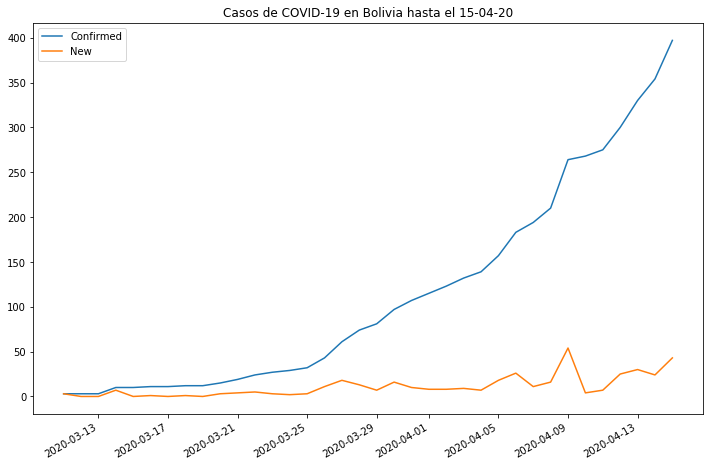

In [42]:
# Create plot object
ax = df_bo.plot(
    y=["Confirmed", "New"],
    title=f"Casos de COVID-19 en Bolivia hasta el {df_bo.index.max().strftime('%d-%m-%y')}",
    legend=True,
    x_compat=True,
    figsize = (12, 8),
)

# Format x-axis ticks and tick labels
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y"))
ax.tick_params(
    axis="both",
    which="major",
    labelsize=18,
)

# Format labels
plt.ylabel("Número de Casos")
plt.xlabel("Fecha")
plt.legend(["Total", "Nuevos"], fontsize=18)

# Add thicker horizontal axis
ax.axhline(
    y=0,
    color="black",
    linewidth=1.3,
    alpha=0.7,
    zorder=1,
)

# Add subtitle
offset = 1
line = "_" * (int(df_bo.shape[0] * 3.2) - offset)
signature = "Juan Manuel Contreras (@juanmaphd) con datos de Johns Hopkins University"
ax.text(
    x=df_bo.index.min() - pd.Timedelta(days=4),
    y=-(df_bo["Confirmed"].max() / 2.65),
    s=f"{line}\n{' ' * (int(df_bo.shape[0] * 1.5) + offset * 2)}{signature}",
    color="grey",
    alpha=.7
)

# Draw plot
plt.show()

# Save plot
ax.get_figure().savefig(os.path.join(plots_path, f"bolivia_{df_bo.index.max().strftime('%d_%m_%y')}.png"))

# Plot Latin America graph

In [ ]:
# Join to country population
df_sa = df_sa.reset_index().merge(
    df_population[["Country_Region", "Population"]],
    on="Country_Region",
    how="inner"
).set_index("index")

# Compute confirmed per 100k
df_sa["Confirmed_Per_100k"] = df_sa["Confirmed"] / df_sa["Population"] * 100000

In [ ]:
# Create plot object
fig, ax = plt.subplots(figsize=(12, 8))

# Draw plots
for i, key_grp in enumerate(df_sa.groupby(['Country_Region'])):
    key, grp = key_grp
    grp.plot(
        x="Day_Count",
        y="Confirmed_Per_100k",
        label=key,
        ax=ax,
        color=latam_palette[i],
        path_effects=[
            pe.Stroke(linewidth=5, foreground='black'),
            pe.Normal()
        ],
    )

# Add title and axes labels
plt.title(f"Casos de COVID-19 por 100 mil habitantes en Sudamérica hasta el {df_sa.index.max().strftime('%d-%m-%y')}",)
plt.ylabel("Número de Casos por 100 Mil Habitantes")
plt.xlabel("Número de Dias desde el Primer Caso")

# Add thicker horizontal axis
ax.axhline(
    y=0,
    color="black",
    linewidth=1.3,
    alpha=0.7,
    zorder=1,
)

# Add subtitle
offset = 1
line = "_" * (int(df_sa["Day_Count"].max() * 2.3))
signature = "Juan Manuel Contreras (@juanmaphd) con datos de Johns Hopkins University"
ax.text(
    x=-5,
    y=-(df_latam["Confirmed_Per_100k"].max() / 4.3),
    s=f"{line}\n{' ' * (int(df_sa['Day_Count'].max() * 1.1 + offset))}{signature}",
    color="grey",
    alpha=.7
)

# Draw plot
plt.show()

# Save plot
ax.get_figure().savefig(os.path.join(plots_path, f"latam_{df_bo.index.max().strftime('%d_%m_%y')}.png"))